# Simulation of the growth and development of an apple tree 1 - Organ Development

## Loading meteo data

In [1]:
# Loading meteo data
import meteo ; reload(meteo)
from meteo import *
init_temperatures()

In [2]:
# Example of Use

get_temperature(date(2010,1,1))

from matplotlib.pyplot import plot, show

plot(get_all_dates(), get_all_temperatures())
show()

## Modelling thermal time

Thermal time consists in accumulating each day the temperature above a given threshold. 

In [3]:
base_temperature = 5

class ThermalTime:
    def __init__(self, base_temperature):
        self.base_temperature = base_temperature
    def get_effective_temperature(self, cdate):
        ctemp = get_temperature(cdate)
        return max(0, ctemp-self.base_temperature)
    def get_effective_temperatures(self, beg_date, end_date):
        return [max(0,ctemp-self.base_temperature) for ctemp in get_temperatures(beg_date, end_date)]

# a global variable that makes it possible to compute effective temperature
mthermaltime = ThermalTime(base_temperature)

## Organ final size

We distinguish the organ produced at the begining of the growth unit (preformed) from the other ones.

In [4]:
# Parameters
FinalLeafArea1 = 12.
FinalLeafArea2 = 25.

InternodeLength1 = 1
InternodeLength2 = 2.5

InternodeRadius = 0.3 

In [5]:
def leaf_area(rank):
    if rank < 7:
        return FinalLeafArea1
    else:
        return FinalLeafArea2

def internode_length(rank):
    if rank < 7:
        return InternodeLength1
    else:
        return InternodeLength2        

## Organ expansion

Growth will be modelled with a logistic function of the shape.

<center>
$ s(t) = \frac{A}{1+exp^{-\frac{t-t_{ip}}{b}}}$
</center>

With $A$ the maximum size, $t_{ip}$ the time at inflexion point and $b$ a slope parameter.
Its derivatives that gives the rate of growth will be

<center>
$ \frac{ds}{dt} = \frac{A.exp^{-\frac{t-t_{ip}}{b}} }{ b.(1+exp^{-\frac{t-t_{ip}}{b}})^2}$
</center>


In [10]:
from math import exp

def growth_logistic(ttime, finalsize, tip, b):
    return finalsize / (1 + exp(-(ttime-tip)/b ))

def growth_logistic_at_date(begdate, cdate, finalsize, tip, b):
    ttime = sum(mthermaltime.get_effective_temperatures(begdate, cdate))
    return growth_logistic(ttime, finalsize, tip, b)

def growth_rate(ttime, finalsize, tip, b):
    g = exp(-(ttime-tip)/b )
    return (finalsize * g)  / ( b * pow((1+g),2))


def growth_rate_at_date(begdate, cdate, finalsize, tip, b):
    ttime = sum(mthermaltime.get_effective_temperatures(begdate, cdate))
    return growth_rate(ttime, finalsize, tip, b)

We can parameterize the previous with the following value for the leaf and internode.

In [9]:
# Parameters
tip_leaf = 100.
tip_internode = 100.

b_leaf = 30.
b_internode = 30.

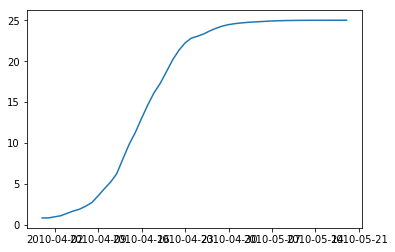

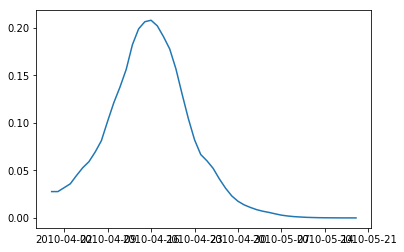

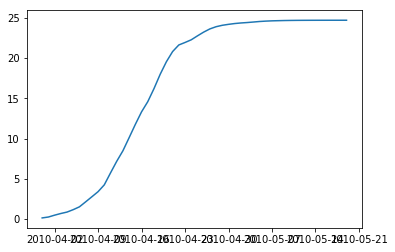

In [11]:
# Example of Use
begdate = date(2010,4,1)
growthperiod = [begdate+timedelta(days=i-1) for i in xrange(50)]

plot(growthperiod, map(lambda d : growth_logistic_at_date(begdate, d, FinalLeafArea2, tip_leaf, b_leaf), growthperiod))
show()

rate = list(map(lambda d : growth_rate_at_date(begdate, d, FinalLeafArea2, tip_leaf, b_leaf), growthperiod))
plot(growthperiod, rate)
show()

from numpy import dot, cumsum
integration = [a*b for a,b in zip(mthermaltime.get_effective_temperatures(begdate, begdate+timedelta(days=50)),rate)]
plot(growthperiod, cumsum(integration))
show()

## Modeling organ development

Using L-Py and the previous equations, we will model the developement of leaves and internodes.

Open in L-Py [this model](./organ.lpy)

## Growth unit length

In [46]:
from namedenum import enum
enum('ShortGU', 'MediumGU', 'LongGU', 'Inflo', 'TrunkGU', 'Blind', 'SyllepticShort', 'SyllepticMedium', 'SyllepticLong')

gulengthlaw = { ShortGU : (5, 0.5),
                MediumGU : (12, 3.5),
                LongGU : (28, 12.2),
                Inflo : (3, 0.2),
                TrunkGU : (50, 6.5)}

from random import gauss

def growth_unit_length(gutype):
    mean, sd = gulengthlaw[gutype]
    return gauss(mean,sd)

## Growth Unit production

The rate of production of metamers by an apex is given with the following equation

$R_i(d) = r_i x T_{eff}(d)$ if $N_i(d)<N_{f,i}$ and $d < D_e$

       = 0 else

with $r_i$ the rate of metamer production in thermal time, $T_{eff}(d)$ the accumulated thermal time at date $d$, $N_{f,i}$ the final number of metamer and $D_e$ the date of plant growth arrest.

In [42]:
metamerprodrate = 0.05
date_end_production = 252

In [43]:
class MetamerProduction:
    def __init__(self, rate, nbfinalmetamer, maxdate = date_end_production):
        self.rate = rate
        self.nbfinalmetamer = nbfinalmetamer
        self.nbmetamer = 0
        self.maxdate = maxdate
        
    def accumulate(self, cdate):
        ttime = mthermaltime.get_effective_temperature(cdate)
        if self.nbmetamer < self.nbfinalmetamer and (cdate -date(cdate.year,1,1)).days < self.maxdate :
            production = self.rate*ttime
            prevnbmetamer = int(self.nbmetamer)
            self.nbmetamer += production
            if int(self.nbmetamer) >  prevnbmetamer:
                return int(self.nbmetamer) - prevnbmetamer
            return 0
        return 0

## Modeling Axis development

Open in L-Py [this model](./axis.lpy)

In [ ]:
# %load axis.lpy
from notebook_util import notebook
exec(notebook('Apple Tree Simulation.ipynb'))

from math import *

cdate = None
def initcdate():
  global cdate
  cdate = meteo.get_first_day_for_temperature()+timedelta(days=120)

initcdate()

def Start():
  initcdate()


def StartEach():
  global cdate
  cdate += timedelta(days=1)

module Meristem
module Leaf
module Internode


Axiom:
  nbmetamer = growth_unit_length(TrunkGU)
  produce Meristem(MetamerProduction(metamerprodrate, nbmetamer))

derivation length: 100
production:

Meristem(p):
  previousnbmetamer = p.nbmetamer
  nbnewmetamer = p.accumulate(cdate)
  for i in xrange(nbnewmetamer):
    nproduce Internode(ParameterSet(length=0.01, finallength = internode_length(rank = previousnbmetamer+i), width=0.01, ttime = 0))
    nproduce /(144) [&(60) Leaf(ParameterSet(area=0, finalarea = leaf_area(rank = 1), width=0.1, ttime = 0)) ]
  nproduce Meristem(p)


Internode(p) :
  cttime = mthermaltime.get_effective_temperature(cdate)
  p.ttime += cttime
  
  p.length += growth_rate(p.ttime, p.finallength, tip_internode, b_internode)*cttime
  p.width += growth_rate(p.ttime, InternodeRadius, tip_internode, b_internode)*cttime
  
  produce Internode(p)

Leaf(p):
  cttime = mthermaltime.get_effective_temperature(cdate)
  p.ttime += cttime
  
  p.area += growth_rate(p.ttime, p.finalarea, tip_leaf, b_leaf)*cttime
  
  produce Leaf(p)

interpretation:

Internode(p) --> _(p.width) F(p.length)

Leaf(p) :
  if p.area > 0:
    width = sqrt(p.area / 1.4)
    length = 2 * width
    produce ,(10)  SetContour(leafsection) TextureVScale(1./length) _(width/2) F(length)

endlsystem
###### INITIALISATION ######

__lpy_code_version__ = 1.1

def __initialiseContext__(context):
	import openalea.plantgl.all as pgl
	PGL_140198936196256 = pgl.ImageTexture("PGL_140198936196256" , "./apple-leaf.png" , )
	PGL_140198936196256.name = "PGL_140198936196256"
	Color_10 = pgl.Texture2D(image = PGL_140198936196256 , )
	Color_10.name = "Color_10"
	context.turtle.setMaterial(10,Color_10)
	import openalea.plantgl.all as pgl
	leafsection = pgl.Polyline2D(	
	    pgl.Point2Array([(-1.01037, 0.524751),(-0.0030303, -0.00517379),(1.01037, 0.503186)]) , 
	    )
	leafsection.name = "leafsection"
	panel_0 = ({'active': True, 'visible': True, 'name': 'Panel 1'},[('Curve2D',leafsection)])
	parameterset = [panel_0,]
	context["__functions__"] = []
	context["__curves__"] = [('leafsection',leafsection),]
	context["__parameterset__"] = parameterset
	context["leafsection"] = leafsection
